In [1]:
%matplotlib notebook

import brian2 as b2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from input_factory import get_step_current
from plot_tools import plot_voltage_and_current_traces

In [7]:
def gen_ou(plot=False):
    I0 = 10.0  # nA
    tau = 10.0  # ms
    #Delta_T = 1.0/20  #ms, sampling freq = 20 kHz
    Delta_T = 1.0/10  #ms, sampling freq = 20 kHz
    #sigma = 1.0  # unitless
    sigma_0 = 1.0  # unitless
    Delta_sigma = 2.0  # unitless
    f = 0.2 * 0.001  # kHz 
    
    
    len_current = 10000  # ms
    len = int(len_current / Delta_T)  # length of arrays: I and time
    I = np.zeros(len)  # nA
    time = np.arange(0, len_current, Delta_T)  # ms
    sigma = np.zeros(len)  # unitless
    
    I[0] = 0.0
    for counter in range(1, len):
        #print 2*numpy.pi*f*time[counter], numpy.sin(2*numpy.pi*f*time[counter])
        sigma[counter] = sigma_0 * (1 + Delta_sigma * np.sin(2*np.pi*f*time[counter]))
        I[counter] = I[counter-1] + (I0 - I[counter-1])/tau*Delta_T + np.sqrt(2*sigma[counter]**2*Delta_T/tau)*np.random.normal()  # N(0,1)
    
    if plot:
        plt.plot(time, I, lw=0.5)
    
        plt.plot(time, I0*(1-np.exp(-time/tau)), color='red', lw=0.5)
    
        plt.figure()
        plt.plot(time, sigma, color='green', lw=2)
        plt.grid()
    
        plt.show()

    return time, I

<IPython.core.display.Javascript object>


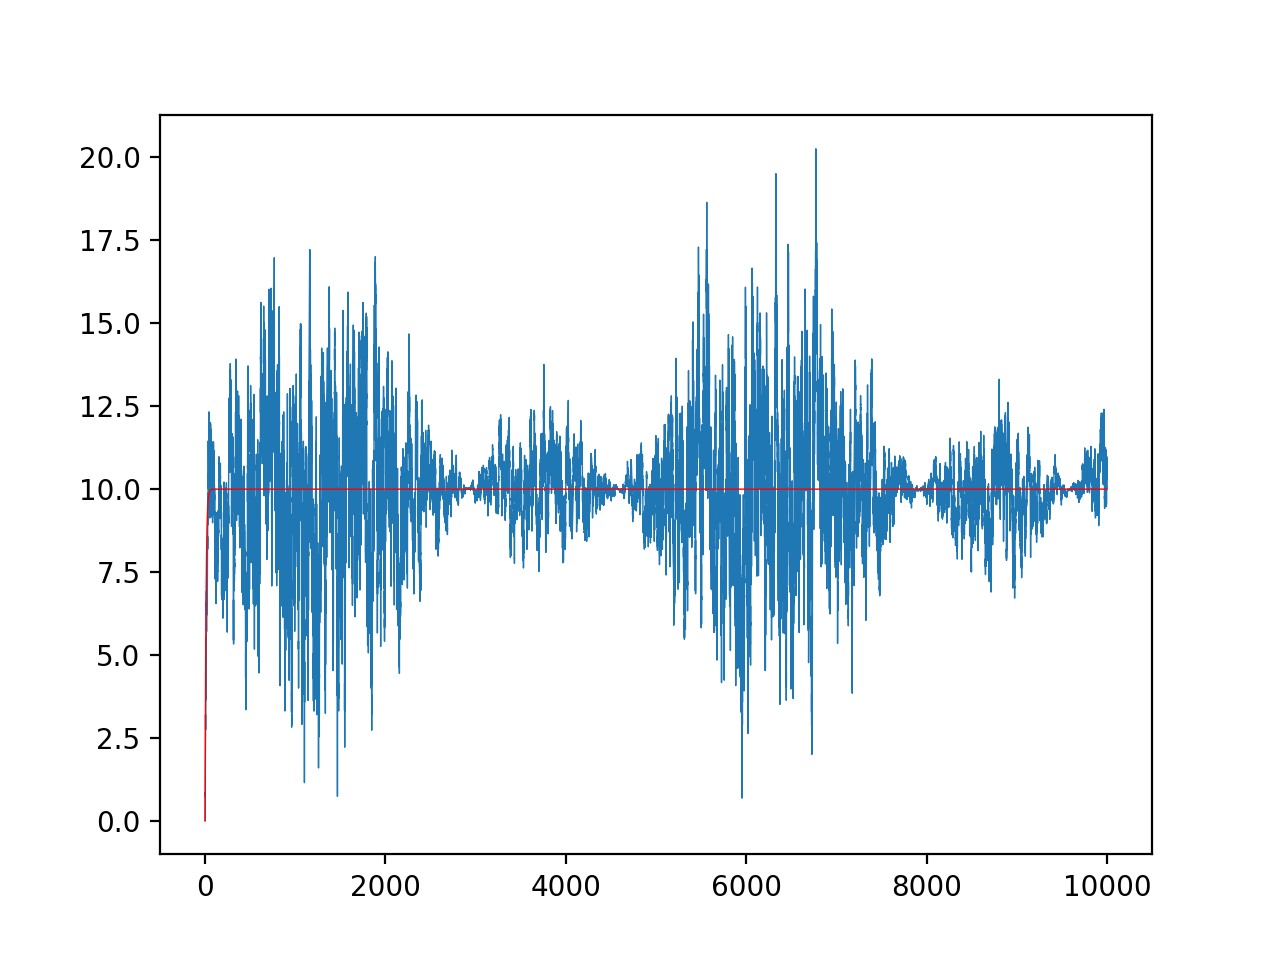

<IPython.core.display.Javascript object>


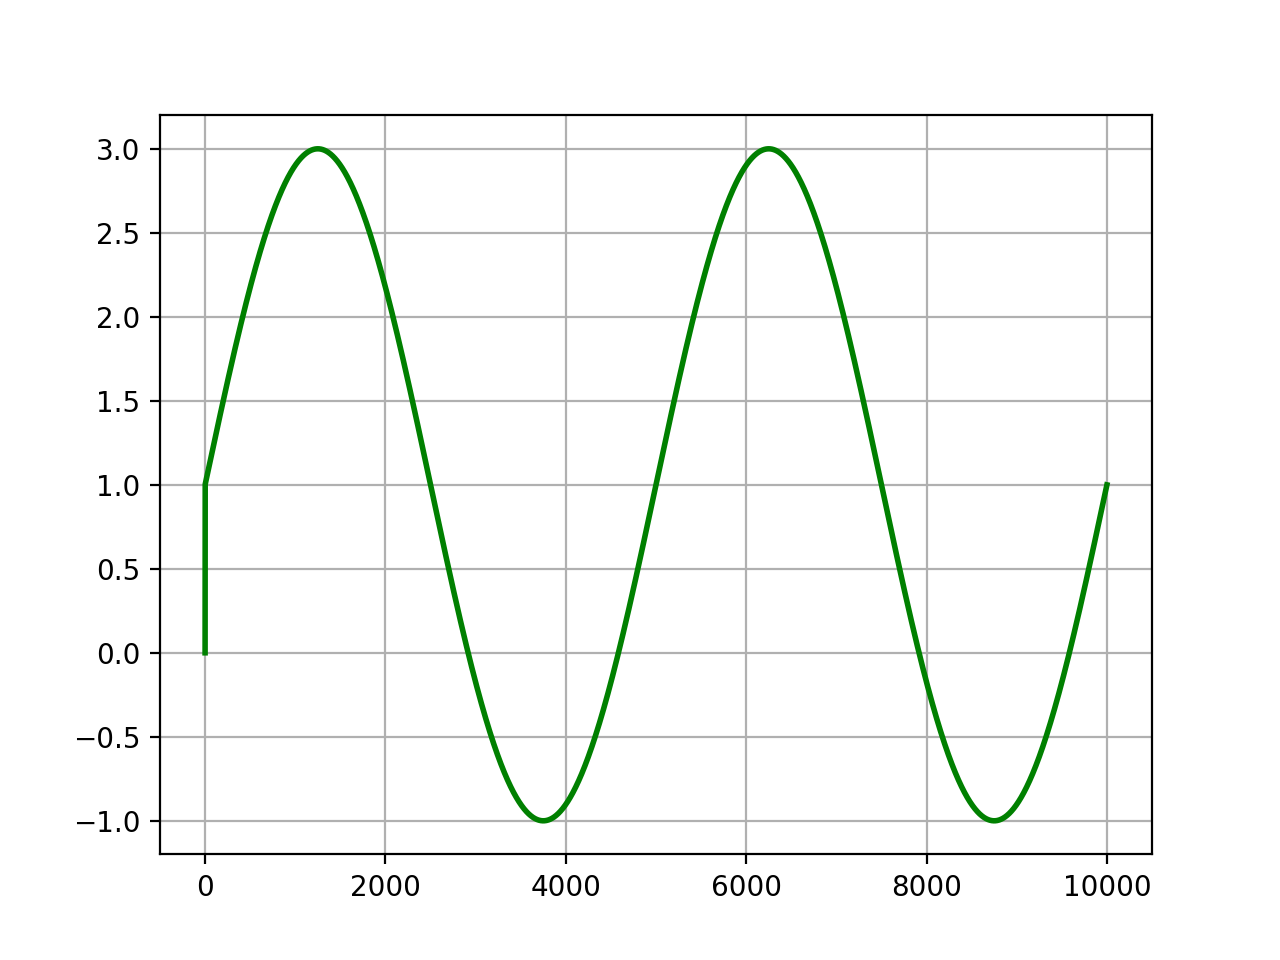

(array([  0.00000000e+00,   1.00000000e-01,   2.00000000e-01, ...,
          9.99970000e+03,   9.99980000e+03,   9.99990000e+03]),
 array([  0.        ,   0.09131433,   0.09821955, ...,  10.85015159,
         10.91032932,  10.72431228]))

In [8]:
gen_ou(True)

In [2]:
model_exc_eqs = '''
dv/dt = (-gL*(v-v_rest) - w1 - w2 + I_ext(t,i) + I_syn)/C : volt

dw1/dt = -w1/tau_w1 : amp
dw2/dt = -w2/tau_w2 : amp
dvt1/dt = -vt1/tau_vt1 : volt
dvt2/dt = -vt2/tau_vt2 : volt

vt = v_0 + vt1 + vt2 : volt
rate = rate_0*exp((v-vt)/del_v): Hz

I_syn = I_exc + I_inh + I_noise : amp
I_noise = -g_noise*(v-E_exc) : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp
dg_noise/dt = -g_noise/tau_exc_2 : siemens
dg_exc/dt = -g_exc/tau_exc_2 : siemens
dg_inh/dt = -g_inh/tau_inh_2 : siemens
'''
reset_eqs = '''
v = v_reset
w1+=amp_w1
w2+=amp_w2
vt1+=amp_vt1
vt2+=amp_vt2
'''

In [ ]:
model_inh_eqs = '''
dv/dt = (-gL*(v-v_rest) - w1 - w2 + I_ext(t,i) + I_syn)/C : volt

dw1/dt = -w1/tau_w1 : amp
dw2/dt = -w2/tau_w2 : amp
dvt1/dt = -vt1/tau_vt1 : volt
dvt2/dt = -vt2/tau_vt2 : volt

vt = v_0 + vt1 + vt2 : volt
rate = rate_0*exp((v-vt)/del_v): Hz

I_syn = I_exc + I_inh + I_noise : amp
I_noise = -g_noise*(v-E_exc) : amp
I_exc = -g_exc*(v-E_exc) : amp
I_inh = -g_inh*(v-E_inh) : amp
dg_noise/dt = -g_noise/tau_exc_2 : siemens
dg_exc/dt = -g_exc/tau_exc_2 : siemens
dg_inh/dt = -g_inh/tau_inh_2 : siemens
'''
reset_eqs = '''
v = v_reset
w1+=amp_w1
w2+=amp_w2
vt1+=amp_vt1
vt2+=amp_vt2
'''

In [1]:
# credits to neurodynex, EPFL for some of the reused code
# note : change to b2. instead of * everywhere
# single neuron tests, started by Sharbat

import numpy
import matplotlib.pyplot as plt
from brian2 import *

In [ ]:
voltage_mon = StateMonitor(G,'v', record=True)
run(100*ms)
plot(voltage_mon.t/ms, voltage_mon.v[0])
xlabel('Time (ms)')
ylabel('v');

In [2]:
def plot_voltage_and_current_traces(voltage_monitor, current, title=None, firing_threshold=None, legend_location=0):
    """plots voltage and current .
    Args:
        voltage_monitor (StateMonitor): recorded voltage
        current (TimedArray): injected current
        title (string, optional): title of the figure
        firing_threshold (Quantity, optional): if set to a value, the firing threshold is plotted.
        legend_location (int): legend location. default = 0 (="best")
    Returns:
        the figure
    """

    assert isinstance(voltage_monitor, StateMonitor), "voltage_monitor is not of type StateMonitor"
    assert isinstance(current, TimedArray), "current is not of type TimedArray"

    time_values_ms = voltage_monitor.t / ms

    # current
    axis_c = plt.subplot(211)
    c = current(voltage_monitor.t, 0)
    max_current = max(current(voltage_monitor.t, 0))
    min_current = min(current(voltage_monitor.t, 0))
    margin = 1.05 * (max_current - min_current)
    # plot the input current time-aligned with the voltage monitor
    plt.plot(voltage_monitor.t / ms, c, "r", lw=2)
    if margin > 0.:
        plt.ylim((min_current - margin) / amp, (max_current + margin) / amp)
    # plt.xlabel("t [ms]")
    plt.ylabel("Input current [A] \n min: {0} \nmax: {1}".format(min_current, max_current))
    plt.grid()
    axis_v = plt.subplot(212)
    plt.plot(time_values_ms, voltage_monitor[0].v / mV, lw=2)
    if firing_threshold is not None:
        plt.plot(
            (voltage_monitor.t / ms)[[0, -1]],
            [firing_threshold / mV, firing_threshold / mV],
            "r--", lw=2
        )
    max_val = max(voltage_monitor[0].v)
    if firing_threshold is not None:
        max_val = max(max_val, firing_threshold)
    min_val = min(voltage_monitor[0].v)
    margin = 0.05 * (max_val - min_val)
    plt.ylim((min_val - margin) / mV, (max_val + margin) / mV)
    plt.xlabel("t [ms]")
    plt.ylabel("membrane voltage [mV]\n min: {0}\n max: {1}".format(min_val, max_val))
    plt.grid()

    if firing_threshold is not None:
        plt.legend(["vm", "firing threshold"], fontsize=12, loc=legend_location)

    if title is not None:
        plt.suptitle(title)
    return axis_c, axis_v

In [3]:
defaultclock.dt = 0.1 * ms
time = 1000 * ms
param_set_exc = 3
param_set_inh = 1 #nfs/fs and otehrs like pv/sst/vip to be seen later

In [4]:
exc_param = numpy.loadtxt('data/exc.txt', delimiter = ',')[param_set_exc]

In [5]:
# w = eta
# vt= gamma

rate0_1 = defaultclock.dt/ms * Hz

stimulus = TimedArray(np.hstack([[c, c, c, 0, 0]
                                 for c in np.random.rand(1000)]),
                                dt=10*ms)

eqs_1 = '''
dv/dt = (-gl_1*(v-El_1)-w1-w2+stimulus(t,i)*namp)/C_1 : volt
dw1/dt = -w1/tau_w1_1 : amp
dw2/dt = -w2/tau_w2_1 : amp
dvt1/dt = -vt1/tau_vt1_1 : volt
dvt2/dt = -vt2/tau_vt2_1 : volt
vt = v0_1 + vt1 + vt2 : volt
rate = rate0_1*exp((v-vt)/deltaV_1): Hz

I: amp
C_1 :farad
gl_1 :siemens
El_1 :volt
v0_1 :volt
deltaV_1 :volt
tau_ref_1 :second
v_reset_1 :volt
rate0_1 :Hz
amp_w1_1 :amp
tau_w1_1 :second
amp_w2_1 :amp
tau_w2_1 :second


amp_vt1_1 :volt
tau_vt1_1 :second
amp_vt2_1 :volt
tau_vt2_1 :second

'''

reset_1='''
v=v_reset_1
w1+=amp_w1_1
w2+=amp_w2_1
vt1+=amp_vt1_1
vt2+=amp_vt2_1
'''

In [6]:
EXC = NeuronGroup(1, model=eqs_1, reset = reset_1, 
                      threshold ='rand()<rate*dt', refractory = exc_param[4]*ms)
EXC.C_1 = exc_param[0] * nF
EXC.gl_1 = exc_param[1] * uS
EXC.El_1 = exc_param[2] * mV
EXC.v_reset_1 = exc_param[3] * mV
EXC.tau_ref_1 = exc_param[4] * ms
EXC.v0_1 = exc_param[5] * mV
EXC.deltaV_1 = exc_param[6] * mV
EXC.amp_w1_1 = exc_param[7] * nA
EXC.tau_w1_1 = exc_param[8] * ms
EXC.amp_w2_1 = exc_param[9] * nA
EXC.tau_w2_1 = exc_param[10] * ms

EXC.amp_vt1_1 = exc_param[11] * mV
EXC.tau_vt1_1 = exc_param[12] * ms
EXC.amp_vt2_1 = exc_param[13] * mV
EXC.tau_vt2_1 = exc_param[14] * ms

EXC.rate0_1 = defaultclock.dt/ms * Hz

# amp = 0.2*namp
# current = np.zeros(int(time))*namp
# current[10:80] = amp

# myI = TimedArray(current,dt=1*ms)

# EXC.I = myI#0.2 * nA
EXC.v = -60*mV#EXC.El_1

In [7]:
voltage_mon = StateMonitor(EXC,'v', record=True)

In [8]:
print('Before v = %s' % EXC.v[0])
run(time)
print('After v = %s' % EXC.v[0])

Before v = -60. mV


BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/brian2/core/network.py", line 841, in before_run
    obj.before_run(run_namespace)
  File "/anaconda3/lib/python3.6/site-packages/brian2/groups/neurongroup.py", line 800, in before_run
    self.equations.check_units(self, run_namespace=run_namespace)
  File "/anaconda3/lib/python3.6/site-packages/brian2/equations/equations.py", line 952, in check_units
    all_variables)
  File "/anaconda3/lib/python3.6/site-packages/brian2/equations/unitcheck.py", line 40, in check_dimensions
    expr_dims = parse_expression_dimensions(expression, variables)
  File "/anaconda3/lib/python3.6/site-packages/brian2/parsing/expressions.py", line 315, in parse_expression_dimensions
    left_dim = parse_expression_dimensions(expr.left, variables)
  File "/anaconda3/lib/python3.6/site-packages/brian2/parsing/expressions.py", line 316, in parse_expression_dimensions
    right_dim = parse_expression_dimensions(expr.right, variables)
  File "/anaconda3/lib/python3.6/site-packages/brian2/parsing/expressions.py", line 315, in parse_expression_dimensions
    left_dim = parse_expression_dimensions(expr.left, variables)
  File "/anaconda3/lib/python3.6/site-packages/brian2/parsing/expressions.py", line 278, in parse_expression_dimensions
    len(func._arg_units)))
  File "<string>", line None
SyntaxError: Function stimulus was called with 2 parameters, needs 1.

Error encountered with object named "neurongroup".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-6-6b105db2b13c>", line 2, in <module>
    threshold ='rand()<rate*dt', refractory = exc_param[4]*ms)

An error occurred when preparing an object.   File "<string>", line None

SyntaxError: Function stimulus was called with 2 parameters, needs 1.
(See above for original error message and traceback.)

In [ ]:
voltage_mon.t

In [ ]:
plot(voltage_mon.t/ms, voltage_mon.v[0])
xlabel('Time (ms)')
ylabel('v');

In [ ]:
plot_voltage_and_current_traces(voltage_monitor, I_ext, title='step_current')

In [ ]:
t_start = 10
t_end = 80
tmp_size = 10 + t_end  # +1 for t=0
tmp = np.zeros((tmp_size, 1)) 
tmp[t_start: t_end + 1, 0] = 100

In [ ]:
tau = 10*ms
runtime = 1*second
stimulus = TimedArray(np.random.rand(int(runtime/defaultclock.dt), 2),
                      dt=defaultclock.dt)

G = NeuronGroup(1, model=eqs_simple, reset = reset_simple, 
                      threshold ='rand()<rate*dt', refractory = exc_param[4]*ms)

M = StateMonitor(G, 'v', record=True)
print('Before v = %s' % G.v[0])
run(100*ms)
print('After v = %s' % G.v[0])
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

In [ ]:
##in case we want to look at synaptic current
param_set_exc = 2
param_set_inh = 0
exc_param = np.loadtxt('data/exc.txt', delimiter = ',')[param_set_exc]
inh_param = np.loadtxt('data/nfs.txt', delimiter = ',')[param_set_inh]
tau_exc_exc, w_exc_exc = preprocessing.Fit_PSP(1.56, 47, exc_param[0]/exc_param[1], 1/exc_param[1])
print('tau_exc_exc: ' + str(tau_exc_exc) + "\tw_exc_exc: " + str(w_exc_exc))

tau_exc_inh, w_exc_inh = preprocessing.Fit_PSP(0.82, 47, inh_param[0]/inh_param[1], 1/inh_param[1])
print('tau_exc_inh: ' + str(tau_exc_inh) + "\tw_exc_inh: " + str(w_exc_inh))

tau_inh_exc, w_inh_exc = preprocessing.Fit_PSP(0.52, 20, exc_param[0]/exc_param[1], 1/exc_param[1])
print('tau_inh_exc: ' + str(tau_inh_exc) + "\tw_inh_exc: " + str(w_inh_exc))

tau_inh_inh, w_inh_inh = preprocessing.Fit_PSP(0.56, 20, inh_param[0]/inh_param[1], 1/inh_param[1])
print('tau_ihn_inh: ' + str(tau_inh_inh) + "\tw_inh_inh: " + str(w_inh_inh))

tau_exc_nh, w_exc_nh = preprocessing.Fit_PSP(0.37, 47, exc_param[0]/exc_param[1], 1/exc_param[1])
print('tau_exc_nh: ' + str(tau_exc_nh) + "\tw_exc_nh: " + str(w_exc_nh))

In [ ]:
## to be added for synaptic noises
'''
I_syn = I_exc + I_inh : amp
dI_exc/dt = -I_exc/tau_exc : amp
dI_inh/dt = -I_inh/tau_inh : amp
'''